<a href="https://colab.research.google.com/github/aleschiavo94/Convolutional-Neural-Network-for-Medical-Imaging-Analysis---Abnormality-detection-in-mammography/blob/main/Baseline_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Project Setup


In [ ]:
  from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 


Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import numpy as np
import pandas as pd 
import ast #Abstract Syntax Trees
import os 
import gc # Garbage Collector

from tensorflow.keras import backend as K # Useful to free GPU and memory
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from keras import layers, optimizers, models, regularizers, metrics
from keras.models import load_model
#ROC-AUC 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from keras.wrappers.scikit_learn import KerasClassifier

#print confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt

BATCH_SIZE = 20
EPOCHS = 100
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

base_path = "/content/gdrive/My Drive/Colab_Notebooks/CIDL/DL Project"
PLOTS_PATH =  os.path.join(base_path, 'plots/Benign-Malign')
train_img_path = os.path.join(base_path, 'numpy data/train_tensor.npy')
train_label_path = os.path.join(base_path, 'numpy data/train_labels.npy')
test_img_path = os.path.join(base_path, 'numpy data/public_test_tensor.npy')
test_label_path = os.path.join(base_path, 'numpy data/public_test_labels.npy')

MODEL_PATH = os.path.join(base_path, "models/Baseline")

# to produce final model report histogram 
AUC_values_1x = []
AUC_values_3x = []
AUC_values_5x = []
TPR_values = []
FPR_values = []
ACC_values_1x = []
ACC_values_3x = []
ACC_values_5x = []

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      gc.collect()

print("Done")

Done


##1.1 Utility Functions

In [ ]:
# ----------------------- Utility Functions -----------------------
def load_training():
  train_images = np.load(train_img_path)
  train_labels = np.load(train_label_path)
  test_images = np.load(test_img_path)
  test_labels = np.load(test_label_path)

  return train_images, train_labels, test_images, test_labels

# Remove baseline samples
def remove_baseline(tensor): 
  max_ind = int(len(tensor)/2)
  indexes = [2*i + 1 for i in range(0, max_ind)]

  return tensor[indexes]

# Interchange the dataset index
def shuffle_dataset(x, y):
  indices = tf.range(start=0, limit=tf.shape(x)[0], dtype=tf.int32)
  shuffled_indices = tf.random.shuffle(indices)

  x = tf.gather(x, shuffled_indices)
  y = tf.gather(y, shuffled_indices)

  x = x.numpy()
  y = y.numpy()

  return x, y

# split dataset into training and validation set 70-30
def split_train_val(dataset, labels):
  train_data_split = dataset[:int(0.8*len(dataset))]
  valid_data_split = dataset[int(0.8*len(dataset)):]
  train_labels_split = labels[:int(0.8*len(labels))]
  valid_labels_split = labels[int(0.8*len(labels)):]

  print(train_data_split.shape)
  print(valid_data_split.shape)
  print(train_labels_split.shape)
  print(valid_labels_split.shape)      

  return train_data_split, valid_data_split, train_labels_split, valid_labels_split

# Unify masses and calcifications 
def labels_mapping(labels):
  labels_local = np.zeros(shape=(int(labels.shape[0]/2),), dtype="float32")
  idx = 0
  for label in labels:
    # Masses
    if label == 1 or label == 2:
      labels_local[idx] = 0
      idx += 1
    # Calcifications
    if label == 3 or label == 4:
      labels_local[idx] = 1
      idx += 1

  return labels_local

# Unify benigns and maligns
def labels_mapping_bm(labels):
  labels_local = np.zeros(shape=(int(labels.shape[0]/2),), dtype="float32")
  idx = 0
  for label in labels:
    # Benign
    if label == 1 or label == 3:
      labels_local[idx] = 0
      idx += 1
    # Malign
    if label == 2 or label == 4:
      labels_local[idx] = 1
      idx += 1

  return labels_local

# Split baseline samples from abnormality samples 
def split_base_abnorm(train_images):
  train_baselines = np.zeros(shape=(2676, 150, 150), dtype="float32")
  train_abnormalities = np.zeros(shape=(2676, 150, 150), dtype="float32")

  #get even posititions
  train_baselines = train_images[::2]
  
  #get odd positions 
  train_abnormalities = train_images[1::2]

  return train_baselines, train_abnormalities

def get_model_predictions(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=False):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

    #np.where(predictions < 0.5, 0, 1)
    #predictions = np.where(predictions < 0.5, 0, 1)

  return predictions


def get_model_pred_prob(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=False):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict_classes(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

  return predictions

# Function to calculate True Positive Rate and False Positive Rate
def calc_TP_FP_rate(y_true, y_pred):    
    # Instantiate counters
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in range(len(y_true)): 
        if y_true[i]==y_pred[i]==1.:
           TP += 1
        if y_pred[i]==1. and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==0.:
           TN += 1
        if y_pred[i]==0. and y_true[i]!=y_pred[i]:
           FN += 1
    
    print("TP: ", TP)
    print("FP: ", FP)
    print("TN: ", TN)
    print("FN: ", FN)
    
    #Precision = TP/(TP+FP)
      #Precision answers the following: How many of those who we labeled as diabetic are actually diabetic?
    precision = TP / (TP + FP)

    #Recall/Sensitivity/TPR = TP/(TP+FN)
        #Recall answers the following question: Of all the people who are diabetic, how many of those we correctly predict?
    tpr = TP / (TP + FN)

    #Specificity = TN/(TN+FP)
        #Specifity answers the following question: Of all the people who are healthy, how many of those did we correctly predict?
    specificity = TN / (TN + FP)

    #FPR  = 1 - Specificity =  FP/FP+TN
    fpr = FP / (FP + TN)

    return tpr, fpr, precision, specificity

print("Done")

Done


##1.2 Visualization Functions

In [ ]:
# Visualization Data Histogram
def plot_acc(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure()
  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  return plt

def plot_loss(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  return plt

def plot_roc(preds, names, titles='ROC curve'):
    plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    for pred, name in zip(preds, names):
        fpr, tpr, _ = roc_curve(test_labels, pred)
        auc_keras = auc(fpr, tpr)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label=(name +' (area = {:.3f})'.format(auc_keras)))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='lower right')
    plt.show()

def plot_confusion_matrix(model,
                          classes,
                          dataset, 
                          labels,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    Y_pred = model.predict(test_datagen.flow(dataset,
                                            labels,
                                            batch_size=21,
                                            shuffle=False),
                          steps=len(dataset) // BATCH_SIZE)

    np.where(Y_pred < 0.5, 0, 1)
    y_pred = np.where(Y_pred < 0.5, 0, 1)

    print('Confusion Matrix')
    cm = confusion_matrix(labels, y_pred)

    #print(cm)
    #print('Classification Report')
    print(classification_report(labels, y_pred))


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt

# Visualization Detail Metric
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    if metrics[-1] != metric:
      plt.figure()

  return plt, cm

def plot_AUC(model, dataset, labels):
  y_pred_keras = get_model_predictions(model, dataset, labels, len(dataset))
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, y_pred_keras)
  #thresholds_keras = np.linspace(0,1,num=100)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  #plt.show()

  return auc_keras, plt
print("Done")

Done


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 3.Stacking Baseline as layer below Abnormality

##2 Data Preparation


In [ ]:
# Get images and labels (test, train)
train_images, train_labels, test_images, test_labels = load_training()

print("Train shape: ", train_images.shape)
print("Train labels shape: ", train_labels.shape)
print()
print("Test shape: ", test_images.shape)
print("Test labels shape: ", test_labels.shape)

Train shape:  (5352, 150, 150)
Train labels shape:  (5352,)

Test shape:  (672, 150, 150)
Test labels shape:  (672,)


In [ ]:
train_baselines, train_abnormalities = split_base_abnorm(train_images)
test_baselines, test_abnormalities = split_base_abnorm(test_images)

print("Train baselines shape: ", train_baselines.shape)
print("Train abnormalities shape: ", train_abnormalities.shape)
print("Test baselines shape: ", test_baselines.shape)
print("Test abnormalities shape: ", test_abnormalities.shape)

Train baselines shape:  (2676, 150, 150)
Train abnormalities shape:  (2676, 150, 150)
Test baselines shape:  (336, 150, 150)
Test abnormalities shape:  (336, 150, 150)


In [ ]:
#stack abnormality on top of the relative baseline
baseline = train_images[0]
abnormality = train_images[1]

print(train_baselines.shape)
print(train_abnormalities.shape)

train_images = np.stack([train_abnormalities, train_baselines, train_abnormalities], axis=3)
print("Staked shape:", train_images.shape)

(2676, 150, 150)
(2676, 150, 150)
Staked shape: (2676, 150, 150, 3)


In [ ]:
train_labels = labels_mapping(train_labels)
test_labels = labels_mapping(test_labels)

print("Train labels shape: ", train_labels.shape)
print("Test labels shape: ", test_labels.shape)

Train labels shape:  (2676,)
Test labels shape:  (336,)


In [ ]:
# Suffle index (Previous dataset is ordered)
train_images, train_labels = shuffle_dataset(train_images, train_labels)

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split = split_train_val(train_images, train_labels)  

(2140, 150, 150, 3)
(536, 150, 150, 3)
(2140,)
(536,)


In [ ]:
test_images = test_abnormalities.reshape(test_abnormalities.shape + (1,)) #(2676, 150, 150, 1)
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (2676, 150, 150, 3)
Test shape:  (336, 150, 150, 3)


##2.1 Data Visualization

	Baseline patch           VS	 Abnormality patch


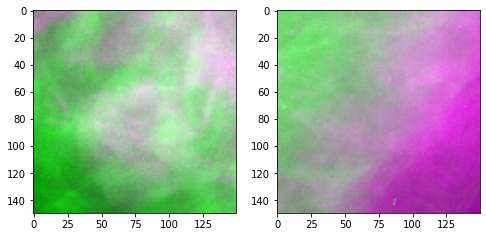

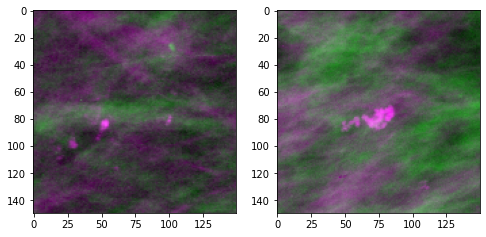

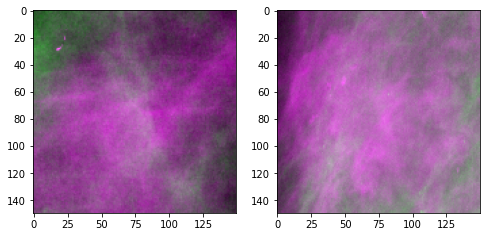

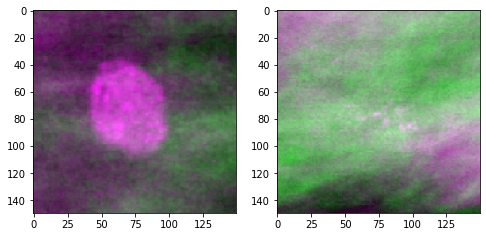

In [ ]:
from PIL import Image
from matplotlib.pyplot import figure, imshow, axis

#train_images = train_images.reshape(train_images.shape + (1,)) #(2676, 150, 150, 1)
#test_images = test_images.reshape(test_images.shape + (1,)) #(2676, 150, 150, 1)

def display_samples(idx):
  assert idx % 2 == 0
  counter = 0
  fig = figure(figsize=(8,4))
  while counter < 2:
    img = train_images[idx]
    pil_img = tf.keras.preprocessing.image.array_to_img(img)
    a=fig.add_subplot(1, 2, counter+1)
    imshow(pil_img,cmap='Greys_r')

    counter += 1
    idx += 1

print("\tBaseline patch           VS\t Abnormality patch")
display_samples(0)
display_samples(2)
display_samples(4)
display_samples(6)

##2.4 Data Augmentation

In [ ]:
# Train data augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=20,
    zoom_range=(0.5,1.5),
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 

print("Done")

Done


In [ ]:
INPUT_SHAPE = (150, 150, 3)
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 20

In [ ]:
METRICS = [
      metrics.BinaryAccuracy(name='acc'),
      #metrics.Precision(name='precision'),
      #metrics.Recall(name='recall'),
      #metrics.AUC(name='auc'),
      # metrics.TruePositives(name='tp'),
      # metrics.FalsePositives(name='fp'),
      # metrics.TrueNegatives(name='tn'),
      # metrics.FalseNegatives(name='fn'),     
]

es = tf.keras.callbacks.EarlyStopping(
     monitor='val_loss', patience=20, verbose=0,
     mode='auto', restore_best_weights=True
)

## 3.3.1 InceptionV3: 2-Fine-Tuning Strategy With Data Augmentation 3x256

In [ ]:
METRICS = [
      metrics.BinaryAccuracy(name='acc'),
      #metrics.Precision(name='precision'),
      #metrics.Recall(name='recall'),
      #metrics.AUC(name='auc'),
      # metrics.TruePositives(name='tp'),
      # metrics.FalsePositives(name='fp'),
      # metrics.TrueNegatives(name='tn'),
      # metrics.FalseNegatives(name='fn'),     
]

es = tf.keras.callbacks.EarlyStopping(
     monitor='val_loss', patience=40, verbose=0,
     mode='auto', restore_best_weights=True
)

In [ ]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 74, 74, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 74, 74, 32)   96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 74, 74, 32)   0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/Baseline/best_InceptionV3_2FT_3x')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

conv_base.trainable = True
#unfreeze last 2 Inception modules
for layer in conv_base.layers[:249]:
   layer.trainable = False
for layer in conv_base.layers[249:]:
   layer.trainable = True

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=300,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)              

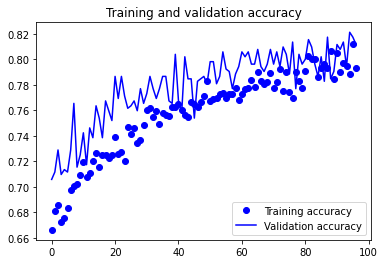

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

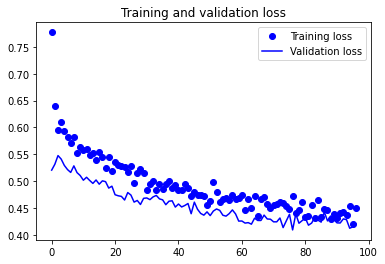

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")
ACC_values_3x.append(test_accuracy)

16/16 [==============================] - 1s 29ms/step - loss: 0.4696 - acc: 0.7719

---------------------------------
Accuracy: 77.19 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.78      0.77      0.78       179
         1.0       0.74      0.75      0.75       157

    accuracy                           0.76       336
   macro avg       0.76      0.76      0.76       336
weighted avg       0.76      0.76      0.76       336



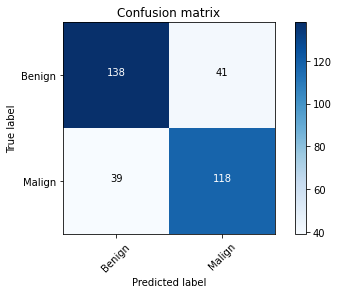

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

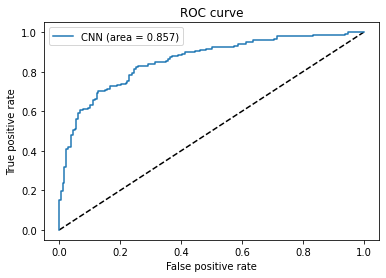

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values_3x.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  118
FP:  41
TN:  138
FN:  39

TPR(Recall): 		 0.7516
FPR: 			 0.2291

Precision: 		 0.7421
TNR(Specificity): 	 0.7709


In [ ]:
#free RAM 
del model
del conv_base
del train_images_split 
del valid_images_split 
del train_labels_split 
del valid_labels_split

## 5.5.1 InceptionV3: All-Fine-Tuning Strategy With Data Augmentation 5x256

In [ ]:
METRICS = [
      metrics.BinaryAccuracy(name='acc'),
      #metrics.Precision(name='precision'),
      #metrics.Recall(name='recall'),
      #metrics.AUC(name='auc'),
      # metrics.TruePositives(name='tp'),
      # metrics.FalsePositives(name='fp'),
      # metrics.TrueNegatives(name='tn'),
      # metrics.FalseNegatives(name='fn'),     
]

es = tf.keras.callbacks.EarlyStopping(
     monitor='val_loss', patience=40, verbose=0,
     mode='auto', restore_best_weights=True
)

In [ ]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/Baseline/best_InceptionV3_ALLFT_DA_5x')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze all convolutional blocks
for layer in model.layers:
    layer.trainable = True 


model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=500,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dropout (Dropout)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4718848   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

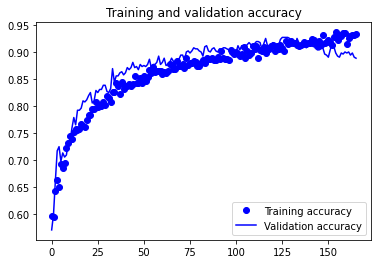

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

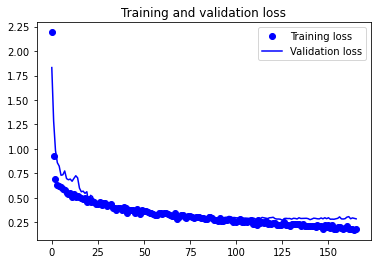

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")
ACC_values_5x.append(test_accuracy)

16/16 [==============================] - 0s 29ms/step - loss: 0.3526 - acc: 0.8438

---------------------------------
Accuracy: 84.38 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.94      0.75      0.84       179
         1.0       0.77      0.95      0.85       157

    accuracy                           0.85       336
   macro avg       0.86      0.85      0.84       336
weighted avg       0.86      0.85      0.84       336



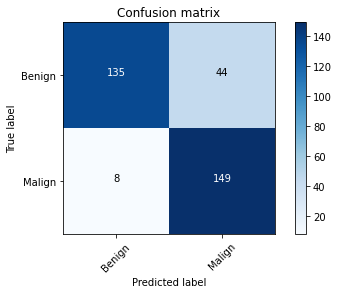

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

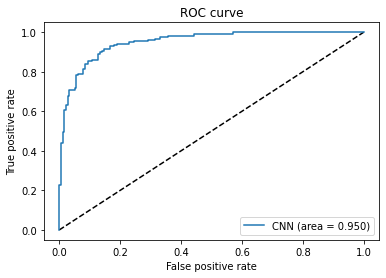

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values_5x.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  149
FP:  44
TN:  135
FN:  8

TPR(Recall): 		 0.949
FPR: 			 0.2458

Precision: 		 0.772
TNR(Specificity): 	 0.7542


In [ ]:
models.save_model(model, os.path.join(MODEL_PATH, 'InceptionV3_ALLFT_5x256_stacking.h5'))

In [ ]:
#free RAM 
del model
del conv_base
del train_images_split 
del valid_images_split 
del train_labels_split 
del valid_labels_split

# 4.Concatenating Baseline & relative Abnormality horizontally

##2 Data Preparation





In [ ]:
# Get images and labels (test, train)
train_images, train_labels, test_images, test_labels = load_training()

print("Train shape: ", train_images.shape)
print("Train labels shape: ", train_labels.shape)
print()
print("Test shape: ", test_images.shape)
print("Test labels shape: ", test_labels.shape)

Train shape:  (5352, 150, 150)
Train labels shape:  (5352,)

Test shape:  (672, 150, 150)
Test labels shape:  (672,)


In [ ]:
train_baselines, train_abnormalities = split_base_abnorm(train_images)
test_baselines, test_abnormalities = split_base_abnorm(test_images)

print("Train baselines shape: ", train_baselines.shape)
print("Train abnormalities shape: ", train_abnormalities.shape)
print("Test baselines shape: ", test_baselines.shape)
print("Test abnormalities shape: ", test_abnormalities.shape)

Train baselines shape:  (2676, 150, 150)
Train abnormalities shape:  (2676, 150, 150)
Test baselines shape:  (336, 150, 150)
Test abnormalities shape:  (336, 150, 150)


In [ ]:
#concatenate abnormality beside to the relative baseline
baseline = train_images[0]
abnormality = train_images[1]

print(train_baselines.shape)
print(train_abnormalities.shape)


train_images = np.concatenate([train_baselines, train_abnormalities], axis=2)
test_images = np.concatenate([test_baselines, test_abnormalities], axis=2)

#train_images = tf.keras.backend.concatenate(
#                  [train_baselines, train_abnormalities],
#                  axis=2
#)
#train_images = train_images.numpy()

print("Staked train shape:", train_images.shape)
print("Staked test shape:", test_images.shape)

train_images = train_images.reshape(train_images.shape + (1,)) 
test_images = test_images.reshape(test_images.shape + (1,)) 

(2676, 150, 150)
(2676, 150, 150)
Staked train shape: (2676, 150, 300)
Staked test shape: (336, 150, 300)


##2.1 Data Visualization

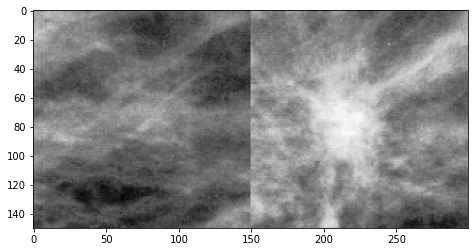

In [ ]:
from PIL import Image
from matplotlib.pyplot import figure, imshow, axis

fig = figure(figsize=(8,4))
img = train_images[3]
pil_img = tf.keras.preprocessing.image.array_to_img(img)
a=fig.add_subplot(1, 1, 1)
imshow(pil_img,cmap='Greys_r')

In [ ]:
train_labels = labels_mapping(train_labels)
test_labels = labels_mapping(test_labels)

print("Train labels shape: ", train_labels.shape)
print("Test labels shape: ", test_labels.shape)

Train labels shape:  (2676,)
Test labels shape:  (336,)


In [ ]:
# Suffle index (Previous dataset is ordered)
train_images, train_labels = shuffle_dataset(train_images, train_labels)

In [ ]:
#repeat greyscale layer x3 
if train_images.shape[3] == 1:
  train_images = np.repeat(train_images, 3, axis = 3)

if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (2676, 150, 300, 3)
Test shape:  (336, 150, 300, 3)


In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split = split_train_val(train_images, train_labels)  

(2140, 150, 300, 3)
(536, 150, 300, 3)
(2140,)
(536,)


##2.4 Data Augmentation

In [ ]:
# Train data augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=20,
    zoom_range=(0.5,1.5),
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 

print("Done")

Done


## InceptionV3: All-Fine-Tuning Strategy With Data Augmentation 3x256

In [ ]:
INPUT_SHAPE = (150, 300, 3)
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 20
EPOCHS = 200

In [ ]:
METRICS = [
      metrics.BinaryAccuracy(name='acc'),
      #metrics.Precision(name='precision'),
      #metrics.Recall(name='recall'),
      #metrics.AUC(name='auc'),
      # metrics.TruePositives(name='tp'),
      # metrics.FalsePositives(name='fp'),
      # metrics.TrueNegatives(name='tn'),
      # metrics.FalseNegatives(name='fn'),     
]

es = tf.keras.callbacks.EarlyStopping(
     monitor='val_loss', patience=40, verbose=0,
     mode='auto', restore_best_weights=True
)

In [ ]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(INPUT_SHAPE))
conv_base.summary()

87916544/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 149, 32)  864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 149, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 149, 32)  0           batch_normalization[0][0]        
______________________

In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/Baseline/best_InceptionV3_ALLFT_DA_5x')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze all convolutional blocks
for layer in model.layers:
    layer.trainable = True 


model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=500,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 49152)             0         
_________________________________________________________________
dropout (Dropout)            (None, 49152)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               12583168  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

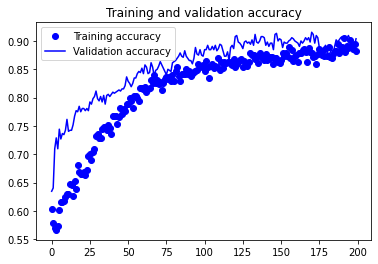

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

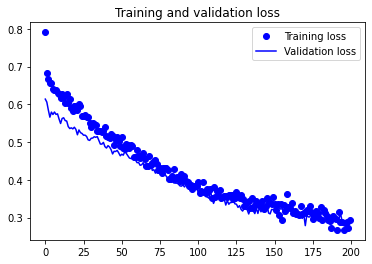

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")
ACC_values_3x.append(test_accuracy)

16/16 [==============================] - 1s 62ms/step - loss: 0.3233 - acc: 0.8781

---------------------------------
Accuracy: 87.81 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.94      0.84      0.88       179
         1.0       0.84      0.94      0.88       157

    accuracy                           0.88       336
   macro avg       0.89      0.89      0.88       336
weighted avg       0.89      0.88      0.88       336



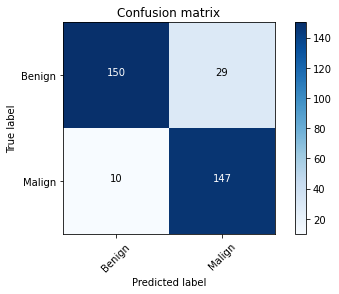

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

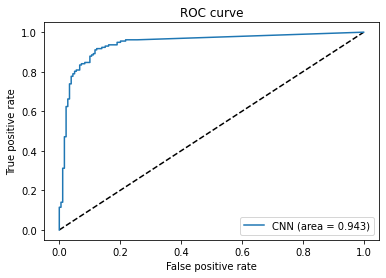

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values_3x.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  147
FP:  29
TN:  150
FN:  10

TPR(Recall): 		 0.9363
FPR: 			 0.162

Precision: 		 0.8352
TNR(Specificity): 	 0.838


In [ ]:
#free RAM 
del model
del conv_base
del train_images_split 
del valid_images_split 
del train_labels_split 
del valid_labels_split

## InceptionV3: All-Fine-Tuning Strategy With Data Augmentation 5x256

In [ ]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 300, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 149, 32)  864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 149, 32)  96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 149, 32)  0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/Baseline/best_InceptionV3_ALLFT_DA_5x')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze all convolutional blocks
for layer in model.layers:
    layer.trainable = True 


model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 49152)             0         
_________________________________________________________________
dropout (Dropout)            (None, 49152)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               12583168  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

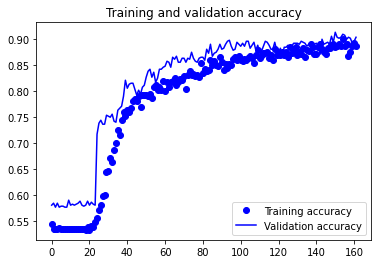

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

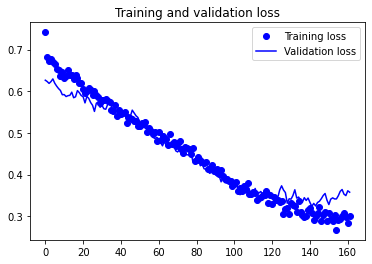

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")
ACC_values_5x.append(test_accuracy)

16/16 [==============================] - 1s 48ms/step - loss: 0.3366 - acc: 0.8781

---------------------------------
Accuracy: 87.81 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.89       179
         1.0       0.85      0.92      0.88       157

    accuracy                           0.88       336
   macro avg       0.88      0.89      0.88       336
weighted avg       0.89      0.88      0.88       336



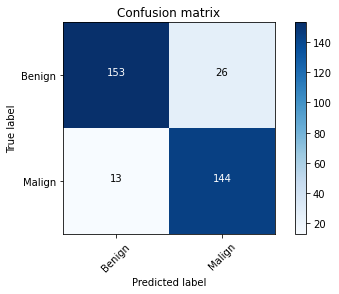

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

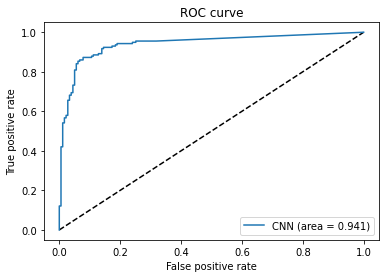

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values_5x.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
MODEL_PATH = os.path.join(base_path, "models/Baseline")
models.save_model(model, os.path.join(MODEL_PATH, '_InceptionV3_ALLFT_DA_5x.h5'))

In [ ]:
#free RAM 
del model
del conv_base
del train_images_split 
del valid_images_split 
del train_labels_split 
del valid_labels_split

# 5.Siamese Network

##2 Data Preparation


In [ ]:
# Get images and labels (test, train)
train_images, train_labels, test_images, test_labels = load_training()

print("Train shape: ", train_images.shape)
print("Train labels shape: ", train_labels.shape)
print()
print("Test shape: ", test_images.shape)
print("Test labels shape: ", test_labels.shape)

Train shape:  (5352, 150, 150)
Train labels shape:  (5352,)

Test shape:  (672, 150, 150)
Test labels shape:  (672,)


In [ ]:
train_baselines, train_abnormalities = split_base_abnorm(train_images)
test_baselines, test_abnormalities = split_base_abnorm(test_images)

print("Train baselines shape: ", train_baselines.shape)
print("Train abnormalities shape: ", train_abnormalities.shape)
print("Test baselines shape: ", test_baselines.shape)
print("Test abnormalities shape: ", test_abnormalities.shape)

Train baselines shape:  (2676, 150, 150)
Train abnormalities shape:  (2676, 150, 150)
Test baselines shape:  (336, 150, 150)
Test abnormalities shape:  (336, 150, 150)


In [ ]:
train_labels = labels_mapping(train_labels)
test_labels = labels_mapping(test_labels)

print("Train labels shape: ", train_labels.shape)
print("Test labels shape: ", test_labels.shape)


Train labels shape:  (2676,)
Test labels shape:  (336,)


In [ ]:
unique, counts = np.unique(train_labels, return_counts=True)
print(unique, counts)
unique, counts = np.unique(test_labels, return_counts=True)
print(unique, counts)

[0. 1.] [1218 1458]
[0. 1.] [179 157]


In [ ]:
# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(2676)
train_abnormalities = train_abnormalities[perm]
train_baselines = train_baselines[perm]
train_labels = train_labels[perm]

In [ ]:
train_baselines = train_baselines.reshape(train_baselines.shape + (1,)) #(2676, 150, 150, 1)
train_abnormalities = train_abnormalities.reshape(train_abnormalities.shape + (1,)) #(2676, 150, 150, 1)
test_abnormalities = test_abnormalities.reshape(test_abnormalities.shape + (1,)) #(2676, 150, 150, 1)
test_baselines = test_baselines.reshape(test_baselines.shape + (1,)) #(2676, 150, 150, 1)

#reshape to expand grayscale to rgb
train_baselines = np.repeat(train_baselines, 3, axis = 3)
train_abnormalities = np.repeat(train_abnormalities, 3, axis = 3)
test_abnormalities = np.repeat(test_abnormalities, 3, axis = 3)
test_baselines = np.repeat(test_baselines, 3, axis = 3)

print("Train baselines shape: ", train_baselines.shape)
print("Train abnormalities shape: ", train_abnormalities.shape)
print("Train labels shape: ", train_labels.shape)
print("Test labels shape: ", test_labels.shape)

Train baselines shape:  (2676, 150, 150, 3)
Train abnormalities shape:  (2676, 150, 150, 3)
Train labels shape:  (2676,)
Test labels shape:  (336,)


In [ ]:
train_abn_split, valid_abn_split, train_abn_labels_split, valid_abn_labels_split = split_train_val(train_abnormalities, train_labels)  
train_base_split, valid_base_split, _, _ = split_train_val(train_baselines, train_labels)  


(2140, 150, 150, 3)
(536, 150, 150, 3)
(2140,)
(536,)
(2140, 150, 150, 3)
(536, 150, 150, 3)
(2140,)
(536,)


## Pairs Generator

In [ ]:
def double_generator(train_abn_images, train_base_images, train_labels, batch_size=128):

  gen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=20,
    zoom_range=(0.5,1.5),
    horizontal_flip=True,
    fill_mode='nearest'
  )

  gen.fit(train_abn_images)

  gen_abn = gen.flow(train_abn_images, train_labels,  batch_size=batch_size, shuffle=True)
  gen_base = gen.flow(train_base_images, train_labels, batch_size=batch_size, shuffle=True)

  while True:
    abn_img, abn_label = gen_abn.next()
    base_img, _ = gen_base.next()
    yield [abn_img, base_img], abn_label


train_generator = double_generator(train_abn_split, train_base_split, train_abn_labels_split, batch_size=128)
validation_generator = double_generator(valid_abn_split, valid_base_split, valid_abn_labels_split, batch_size=128)
test_generator = double_generator(test_abnormalities, test_baselines, test_labels, batch_size=128)

In [ ]:
from keras.models import Model
from tensorflow.keras.utils import plot_model

INPUT_SHAPE = (150, 150, 3)
MODEL_PATH = os.path.join(base_path, "models/PreTrained-Masses-Calcifications/ResNet")

def create_siamese(CNN_core):

  # CNN core ResNet_flatten_dense_256x3_last_3_blocks_trainable.h5
  pretrained = models.load_model(os.path.join(MODEL_PATH, CNN_core))
  
  pretrained.trainable = True
  for prelayer in pretrained.layers:
    if "inception_v3" in prelayer.name:
       
      #unfreeze last 3 Inception modules
      for layer in prelayer.layers[:218]:
        layer.trainable = False
      for layer in prelayer.layers[218:]:
        layer.trainable = True

  x = pretrained.layers[-2].output
  output = layers.Dense(2048, activation='relu', name='extractor')(x)
  cnn = Model(pretrained.input, output)

  # Feed both input into the same convolutional base
  left_input = layers.Input(shape=INPUT_SHAPE)
  right_input = layers.Input(shape=INPUT_SHAPE)

  left_model = cnn(left_input)
  right_model = cnn(right_input)

  # Compute the difference between the two
  L1_layer = layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
  L1_distance = L1_layer([left_model, right_model])

  # FC layer
  # Add a dense layer with a sigmoid unit to generate the prediction
  prediction = layers.Dense(1, activation='sigmoid')(L1_distance)

  # Instantiate the model
  siamese = models.Model(inputs=[left_input, right_input], outputs=prediction)

  return siamese

## Pretrained ResNet 256x3 as CNN core

In [ ]:
# Instantiate model
CNN_core = 'ResNet_flatten_dense_256x3_last_3_blocks_trainable.h5'
siamese = create_siamese(CNN_core)
siamese.summary()

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

# Callback for checkpointing
checkpoint = tf.keras.callbacks.ModelCheckpoint('siamese_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
#siamese.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

siamese.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS) 

# Train
history_siamese = siamese.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*2676) // 128,
        epochs=200,
        validation_data=validation_generator,
        validation_steps = int(0.2*2676) // 128,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1
)

siamese = models.load_model('siamese_best.h5')
# Save


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
model_3 (Functional)            (None, 2048)         37330176    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2048)         0           model_3[0][0]              

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
16/16 [==============================] - 47s 2s/step - loss: 0.9592 - acc: 0.4977 - val_loss: 0.6075 - val_acc: 0.7227

Epoch 00001: val_loss improved from inf to 0.60749, saving model to siamese_best.h5
Epoch 2/200
16/16 [==============================] - 31s 2s/step - loss: 0.6869 - acc: 0.5699 - val_loss: 0.5917 - val_acc: 0.7695

Epoch 00002: val_loss improved from 0.60749 to 0.59167, saving model to siamese_best.h5
Epoch 3/200
16/16 [==============================] - 29s 2s/step - loss: 0.6246 - acc: 0.6602 - val_loss: 0.5775 - val_acc: 0.7949

Epoch 00003: val_loss improved from 0.59167 to 0.57746, saving model to siamese_best.h5
Epoch 4/200
16/16 [==============================] - 29s 2s/step - loss: 0.6077 - acc: 0.6805 - val_loss: 0.5582 - val_acc: 0.8281

Epoch 00004: val_loss improved from 0.57746 to 0.55818, saving model to siamese_best.h5
Epoch 5/200
16/16 [==============================] - 30s 2s/step - loss: 0.5580 - acc: 0.7321 - val_loss: 0.5449 - val_acc: 

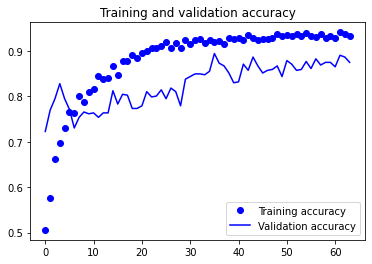

In [ ]:
plt_a = plot_acc(history_siamese)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

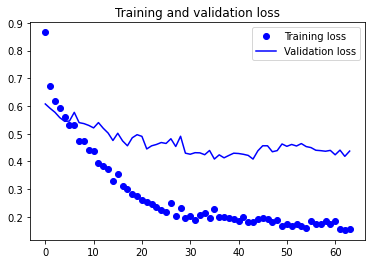

In [ ]:
plt_b = plot_loss(history_siamese)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
siamese = models.load_model('siamese_best.h5')
test_loss, test_accuracy = siamese.evaluate_generator(test_generator, steps=int(336/128))

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



---------------------------------
Accuracy: 83.98 %
---------------------------------



## Pretrained InceptionV3 256x1 ALLFT as CNN core: Unfreeze last 3 Inception Modules

In [ ]:
# Instantiate model
MODEL_PATH = os.path.join(base_path, "models/PreTrained-Masses-Calcifications/Inception")
CNN_core = 'Inception_flatten_dense_256_all_trainable.h5'
siamese = create_siamese(CNN_core)
siamese.summary()

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1)

# Callback for checkpointing
checkpoint = tf.keras.callbacks.ModelCheckpoint('siamese_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
#siamese.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

siamese.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS) 

# Train
history_siamese = siamese.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*2676) // 128,
        epochs=200,
        validation_data=validation_generator,
        validation_steps = int(0.2*2676) // 128,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1
)

siamese = models.load_model('siamese_best.h5')
# Save


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
model_6 (Functional)            (None, 2048)         27047968    input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 2048)         0           model_6[0][0]              

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
16/16 [==============================] - 33s 2s/step - loss: 1.4487 - acc: 0.3490 - val_loss: 1.1753 - val_acc: 0.2012

Epoch 00001: val_loss improved from inf to 1.17529, saving model to siamese_best.h5
Epoch 2/200
16/16 [==============================] - 23s 2s/step - loss: 0.9429 - acc: 0.3059 - val_loss: 0.8240 - val_acc: 0.5020

Epoch 00002: val_loss improved from 1.17529 to 0.82403, saving model to siamese_best.h5
Epoch 3/200
16/16 [==============================] - 24s 2s/step - loss: 0.7216 - acc: 0.5285 - val_loss: 0.6523 - val_acc: 0.6250

Epoch 00003: val_loss improved from 0.82403 to 0.65235, saving model to siamese_best.h5
Epoch 4/200
16/16 [==============================] - 24s 2s/step - loss: 0.6319 - acc: 0.6476 - val_loss: 0.5510 - val_acc: 0.7070

Epoch 00004: val_loss improved from 0.65235 to 0.55101, saving model to siamese_best.h5
Epoch 5/200
16/16 [==============================] - 23s 2s/step - loss: 0.5879 - acc: 0.6856 - val_loss: 0.5328 - val_acc: 

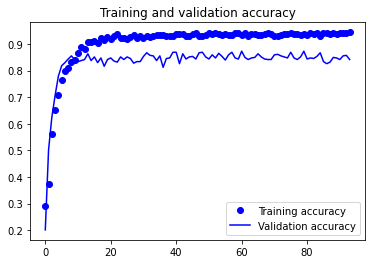

In [ ]:
plt_a = plot_acc(history_siamese)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

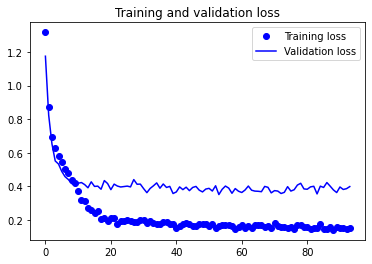

In [ ]:
plt_b = plot_loss(history_siamese)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
siamese = models.load_model('siamese_best.h5')
test_loss, test_accuracy = siamese.evaluate_generator(test_generator, steps=int(336/128))

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



---------------------------------
Accuracy: 82.03 %
---------------------------------



In [ ]:
MODEL_PATH = os.path.join(base_path, "models/Baseline")
models.save_model(model, os.path.join(MODEL_PATH, '_InceptionV3_ALLFT_DA_5x.h5'))

## Pretrained InceptionV3 256x1 ALLFT as CNN core Frozen

In [ ]:
from keras.models import Model
from tensorflow.keras.utils import plot_model

INPUT_SHAPE = (150, 150, 3)
MODEL_PATH = os.path.join(base_path, "models/PreTrained-Masses-Calcifications/ResNet")

def create_siamese_n(CNN_core):

  # CNN core ResNet_flatten_dense_256x3_last_3_blocks_trainable.h5
  pretrained = models.load_model(os.path.join(MODEL_PATH, CNN_core))
  
  pretrained.trainable = False

  x = pretrained.layers[-2].output
  output = layers.Dense(2048, activation='relu', name='extractor')(x)
  cnn = Model(pretrained.input, output)

  # Feed both input into the same convolutional base
  left_input = layers.Input(shape=INPUT_SHAPE)
  right_input = layers.Input(shape=INPUT_SHAPE)

  left_model = cnn(left_input)
  right_model = cnn(right_input)

  # Compute the difference between the two
  L1_layer = layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
  L1_distance = L1_layer([left_model, right_model])

  # FC layer
  # Add a dense layer with a sigmoid unit to generate the prediction
  prediction = layers.Dense(1, activation='sigmoid')(L1_distance)

  # Instantiate the model
  siamese = models.Model(inputs=[left_input, right_input], outputs=prediction)

  return siamese

In [ ]:
METRICS = [
      metrics.BinaryAccuracy(name='acc'),
      #metrics.Precision(name='precision'),
      #metrics.Recall(name='recall'),
      #metrics.AUC(name='auc'),
      # metrics.TruePositives(name='tp'),
      # metrics.FalsePositives(name='fp'),
      # metrics.TrueNegatives(name='tn'),
      # metrics.FalseNegatives(name='fn'),     
]

In [ ]:
# Instantiate model
MODEL_PATH = os.path.join(base_path, "models/PreTrained-Masses-Calcifications/Inception")
CNN_core = 'Inception_flatten_dense_256_all_trainable.h5'
siamese = create_siamese_n(CNN_core)
siamese.summary()

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1)

# Callback for checkpointing
checkpoint = tf.keras.callbacks.ModelCheckpoint('siamese_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
#siamese.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

siamese.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS) 

# Train
history_siamese = siamese.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*2676) // 128,
        epochs=200,
        validation_data=validation_generator,
        validation_steps = int(0.2*2676) // 128,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1
)

siamese = models.load_model('siamese_best.h5')
# Save


Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
model_9 (Functional)            (None, 2048)         27047968    input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 2048)         0           model_9[0][0]             

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
16/16 [==============================] - 31s 2s/step - loss: 0.7983 - acc: 0.5271 - val_loss: 0.5412 - val_acc: 0.7227

Epoch 00001: val_loss improved from inf to 0.54124, saving model to siamese_best.h5
Epoch 2/200
16/16 [==============================] - 23s 2s/step - loss: 0.5062 - acc: 0.7533 - val_loss: 0.4270 - val_acc: 0.8457

Epoch 00002: val_loss improved from 0.54124 to 0.42696, saving model to siamese_best.h5
Epoch 3/200
16/16 [==============================] - 23s 2s/step - loss: 0.4128 - acc: 0.8528 - val_loss: 0.3627 - val_acc: 0.8672

Epoch 00003: val_loss improved from 0.42696 to 0.36273, saving model to siamese_best.h5
Epoch 4/200
16/16 [==============================] - 23s 2s/step - loss: 0.3848 - acc: 0.8402 - val_loss: 0.3749 - val_acc: 0.8594

Epoch 00004: val_loss did not improve from 0.36273
Epoch 5/200
16/16 [==============================] - 23s 2s/step - loss: 0.3594 - acc: 0.8469 - val_loss: 0.3629 - val_acc: 0.8379

Epoch 00005: val_loss did not

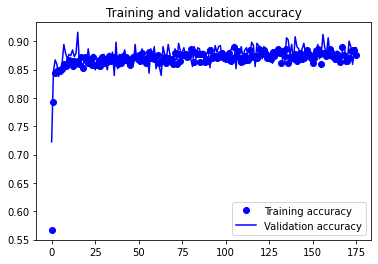

In [ ]:
plt_a = plot_acc(history_siamese)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

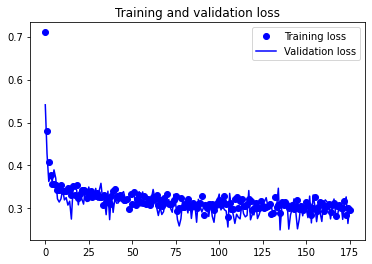

In [ ]:
plt_b = plot_loss(history_siamese)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
siamese = models.load_model('siamese_best.h5')
test_loss, test_accuracy = siamese.evaluate_generator(test_generator, steps=int(336/128))

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



---------------------------------
Accuracy: 84.77 %
---------------------------------



In [ ]:
MODEL_PATH = os.path.join(base_path, "models/Baseline")
models.save_model(model, os.path.join(MODEL_PATH, '_InceptionV3_ALLFT_DA_5x.h5'))

# BENIGN VS MALIGN

# 4.Concatenating Baseline & relative Abnormality horizontally

##2 Data Preparation





In [ ]:
# Get images and labels (test, train)
train_images, train_labels, test_images, test_labels = load_training()

print("Train shape: ", train_images.shape)
print("Train labels shape: ", train_labels.shape)
print()
print("Test shape: ", test_images.shape)
print("Test labels shape: ", test_labels.shape)

Train shape:  (5352, 150, 150)
Train labels shape:  (5352,)

Test shape:  (672, 150, 150)
Test labels shape:  (672,)


In [ ]:
train_baselines, train_abnormalities = split_base_abnorm(train_images)
test_baselines, test_abnormalities = split_base_abnorm(test_images)

print("Train baselines shape: ", train_baselines.shape)
print("Train abnormalities shape: ", train_abnormalities.shape)
print("Test baselines shape: ", test_baselines.shape)
print("Test abnormalities shape: ", test_abnormalities.shape)

Train baselines shape:  (2676, 150, 150)
Train abnormalities shape:  (2676, 150, 150)
Test baselines shape:  (336, 150, 150)
Test abnormalities shape:  (336, 150, 150)


In [ ]:
#concatenate abnormality beside to the relative baseline
baseline = train_images[0]
abnormality = train_images[1]

print(train_baselines.shape)
print(train_abnormalities.shape)


train_images = np.concatenate([train_baselines, train_abnormalities], axis=2)
test_images = np.concatenate([test_baselines, test_abnormalities], axis=2)

#train_images = tf.keras.backend.concatenate(
#                  [train_baselines, train_abnormalities],
#                  axis=2
#)
#train_images = train_images.numpy()

print("Staked train shape:", train_images.shape)
print("Staked test shape:", test_images.shape)

train_images = train_images.reshape(train_images.shape + (1,)) 
test_images = test_images.reshape(test_images.shape + (1,)) 

(2676, 150, 150)
(2676, 150, 150)
Staked train shape: (2676, 150, 300)
Staked test shape: (336, 150, 300)


##2.1 Data Visualization

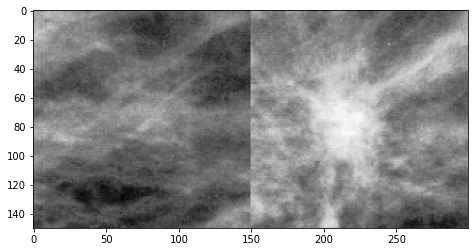

In [ ]:
from PIL import Image
from matplotlib.pyplot import figure, imshow, axis

fig = figure(figsize=(8,4))
img = train_images[3]
pil_img = tf.keras.preprocessing.image.array_to_img(img)
a=fig.add_subplot(1, 1, 1)
imshow(pil_img,cmap='Greys_r')

In [ ]:
train_labels = labels_mapping_bm(train_labels)
test_labels = labels_mapping_bm(test_labels)

print("Train labels shape: ", train_labels.shape)
print("Test labels shape: ", test_labels.shape)

Train labels shape:  (2676,)
Test labels shape:  (336,)


In [ ]:
# Suffle index (Previous dataset is ordered)
train_images, train_labels = shuffle_dataset(train_images, train_labels)

In [ ]:
#repeat greyscale layer x3 
if train_images.shape[3] == 1:
  train_images = np.repeat(train_images, 3, axis = 3)

if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (2676, 150, 300, 3)
Test shape:  (336, 150, 300, 3)


In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split = split_train_val(train_images, train_labels)  

(2140, 150, 300, 3)
(536, 150, 300, 3)
(2140,)
(536,)


##2.4 Data Augmentation

In [ ]:
# Train data augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=20,
    zoom_range=(0.5,1.5),
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 

print("Done")

Done


## InceptionV3: All-Fine-Tuning Strategy With Data Augmentation 3x256

In [ ]:
INPUT_SHAPE = (150, 300, 3)
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 20
EPOCHS = 200

In [ ]:
METRICS = [
      metrics.BinaryAccuracy(name='acc'),
      #metrics.Precision(name='precision'),
      #metrics.Recall(name='recall'),
      #metrics.AUC(name='auc'),
      # metrics.TruePositives(name='tp'),
      # metrics.FalsePositives(name='fp'),
      # metrics.TrueNegatives(name='tn'),
      # metrics.FalseNegatives(name='fn'),     
]

es = tf.keras.callbacks.EarlyStopping(
     monitor='val_loss', patience=40, verbose=0,
     mode='auto', restore_best_weights=True
)

In [ ]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(INPUT_SHAPE))
conv_base.summary()

87916544/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 149, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 149, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 149, 32)  0           batch_normalization[0][0]        
______________________

In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/Baseline/best_InceptionV3_ALLFT_DA_5x_BM')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze all convolutional blocks
for layer in model.layers:
    layer.trainable = True 


model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=500,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 49152)             0         
_________________________________________________________________
dropout (Dropout)            (None, 49152)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               12583168  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

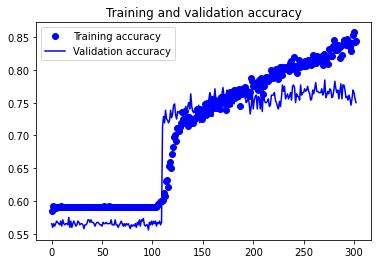

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

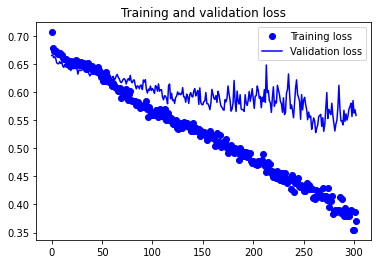

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")
ACC_values_3x.append(test_accuracy)

16/16 [==============================] - 1s 47ms/step - loss: 0.6343 - acc: 0.6406

---------------------------------
Accuracy: 64.06 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.76      0.63      0.69       219
         1.0       0.48      0.63      0.55       117

    accuracy                           0.63       336
   macro avg       0.62      0.63      0.62       336
weighted avg       0.67      0.63      0.64       336



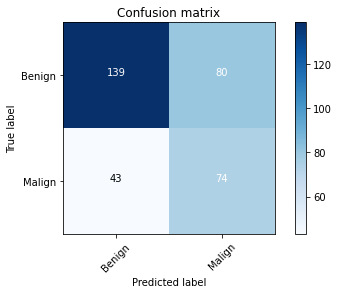

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

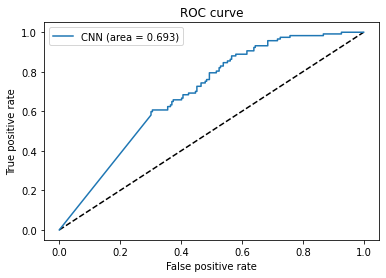

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values_3x.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  74
FP:  80
TN:  139
FN:  43

TPR(Recall): 		 0.6325
FPR: 			 0.3653

Precision: 		 0.4805
TNR(Specificity): 	 0.6347


In [ ]:
#free RAM 
del model
del conv_base
del train_images_split 
del valid_images_split 
del train_labels_split 
del valid_labels_split

## InceptionV3: All-Fine-Tuning Strategy With Data Augmentation 5x256

In [ ]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 300, 3))
conv_base.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 149, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 149, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 149, 32)  0           batch_normalization[0][0]        
______________________

In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/Baseline/best_InceptionV3_ALLFT_DA_5x_BM')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze all convolutional blocks
for layer in model.layers:
    layer.trainable = True 


model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-4), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 49152)             0         
_________________________________________________________________
dropout (Dropout)            (None, 49152)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               12583168  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

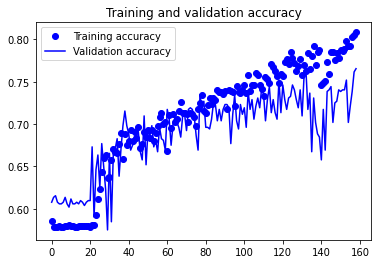

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

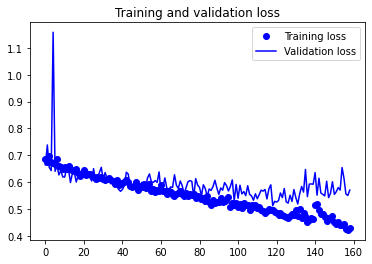

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")
ACC_values_5x.append(test_accuracy)

16/16 [==============================] - 1s 49ms/step - loss: 0.6233 - acc: 0.6875

---------------------------------
Accuracy: 68.75 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.79      0.69      0.74       219
         1.0       0.53      0.65      0.58       117

    accuracy                           0.68       336
   macro avg       0.66      0.67      0.66       336
weighted avg       0.70      0.68      0.68       336



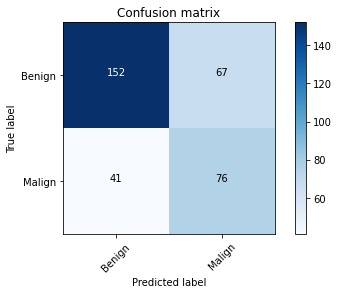

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

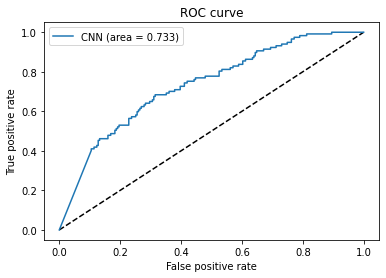

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values_5x.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)

In [ ]:
MODEL_PATH = os.path.join(base_path, "models/Baseline")
models.save_model(model, os.path.join(MODEL_PATH, '_InceptionV3_ALLFT_DA_5x_BM.h5'))

In [ ]:
#free RAM 
del model
del conv_base
del train_images_split 
del valid_images_split 
del train_labels_split 
del valid_labels_split

# 5.Siamese Network

##2 Data Preparation


In [ ]:
# Get images and labels (test, train)
train_images, train_labels, test_images, test_labels = load_training()

print("Train shape: ", train_images.shape)
print("Train labels shape: ", train_labels.shape)
print()
print("Test shape: ", test_images.shape)
print("Test labels shape: ", test_labels.shape)

Train shape:  (5352, 150, 150)
Train labels shape:  (5352,)

Test shape:  (672, 150, 150)
Test labels shape:  (672,)


In [ ]:
train_baselines, train_abnormalities = split_base_abnorm(train_images)
test_baselines, test_abnormalities = split_base_abnorm(test_images)

print("Train baselines shape: ", train_baselines.shape)
print("Train abnormalities shape: ", train_abnormalities.shape)
print("Test baselines shape: ", test_baselines.shape)
print("Test abnormalities shape: ", test_abnormalities.shape)

Train baselines shape:  (2676, 150, 150)
Train abnormalities shape:  (2676, 150, 150)
Test baselines shape:  (336, 150, 150)
Test abnormalities shape:  (336, 150, 150)


In [ ]:
train_labels = labels_mapping_bm(train_labels)
test_labels = labels_mapping_bm(test_labels)

print("Train labels shape: ", train_labels.shape)
print("Test labels shape: ", test_labels.shape)


Train labels shape:  (2676,)
Test labels shape:  (336,)


In [ ]:
unique, counts = np.unique(train_labels, return_counts=True)
print(unique, counts)
unique, counts = np.unique(test_labels, return_counts=True)
print(unique, counts)

[0. 1.] [1568 1108]
[0. 1.] [219 117]


In [ ]:
# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(2676)
train_abnormalities = train_abnormalities[perm]
train_baselines = train_baselines[perm]
train_labels = train_labels[perm]

In [ ]:
train_baselines = train_baselines.reshape(train_baselines.shape + (1,)) #(2676, 150, 150, 1)
train_abnormalities = train_abnormalities.reshape(train_abnormalities.shape + (1,)) #(2676, 150, 150, 1)
test_abnormalities = test_abnormalities.reshape(test_abnormalities.shape + (1,)) #(2676, 150, 150, 1)
test_baselines = test_baselines.reshape(test_baselines.shape + (1,)) #(2676, 150, 150, 1)

#reshape to expand grayscale to rgb
train_baselines = np.repeat(train_baselines, 3, axis = 3)
train_abnormalities = np.repeat(train_abnormalities, 3, axis = 3)
test_abnormalities = np.repeat(test_abnormalities, 3, axis = 3)
test_baselines = np.repeat(test_baselines, 3, axis = 3)

print("Train baselines shape: ", train_baselines.shape)
print("Train abnormalities shape: ", train_abnormalities.shape)
print("Train labels shape: ", train_labels.shape)
print("Test labels shape: ", test_labels.shape)

Train baselines shape:  (2676, 150, 150, 3)
Train abnormalities shape:  (2676, 150, 150, 3)
Train labels shape:  (2676,)
Test labels shape:  (336,)


In [ ]:
train_abn_split, valid_abn_split, train_abn_labels_split, valid_abn_labels_split = split_train_val(train_abnormalities, train_labels)  
train_base_split, valid_base_split, _, _ = split_train_val(train_baselines, train_labels)  


(2140, 150, 150, 3)
(536, 150, 150, 3)
(2140,)
(536,)
(2140, 150, 150, 3)
(536, 150, 150, 3)
(2140,)
(536,)


In [ ]:
train_generator = double_generator(train_abn_split, train_base_split, train_abn_labels_split, batch_size=128)
validation_generator = double_generator(valid_abn_split, valid_base_split, valid_abn_labels_split, batch_size=128)
test_generator = double_generator(test_abnormalities, test_baselines, test_labels, batch_size=128)

## Pretrained InceptionV3 256x3 ALLFT as CNN core

In [ ]:
# Instantiate model
MODEL_PATH = os.path.join(base_path, "models/PreTrained-Benign-Malign")
CNN_core = 'BEST_2_ENSEMBLE.h5'
siamese = create_siamese(CNN_core)
siamese.summary()

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1)

# Callback for checkpointing
checkpoint = tf.keras.callbacks.ModelCheckpoint('siamese_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
#siamese.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

for i, w in enumerate(siamese.weights):
    split_name = w.name.split('/')
    new_name = split_name[0] + '_' + str(i) + '/' + split_name[1] + '_' + str(i)
    siamese.weights[i]._handle_name = new_name

siamese.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS) 

# Train
history_siamese = siamese.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*2676) // 128,
        epochs=200,
        validation_data=validation_generator,
        validation_steps = int(0.2*2676) // 128,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1
)

siamese = models.load_model('siamese_best.h5')
# Save


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
model_4 (Functional)            (None, 2048)         27179552    input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 2048)         0           model_4[0][0]              

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
16/16 [==============================] - 34s 2s/step - loss: 0.5779 - acc: 0.6477 - val_loss: 0.5310 - val_acc: 0.7383

Epoch 00001: val_loss improved from inf to 0.53098, saving model to siamese_best.h5
Epoch 2/200
16/16 [==============================] - 24s 2s/step - loss: 0.5970 - acc: 0.6999 - val_loss: 0.5549 - val_acc: 0.7227

Epoch 00002: val_loss did not improve from 0.53098
Epoch 3/200
16/16 [==============================] - 23s 2s/step - loss: 0.6033 - acc: 0.7001 - val_loss: 0.5562 - val_acc: 0.7090

Epoch 00003: val_loss did not improve from 0.53098
Epoch 4/200
16/16 [==============================] - 24s 2s/step - loss: 0.5849 - acc: 0.6900 - val_loss: 0.5756 - val_acc: 0.7012

Epoch 00004: val_loss did not improve from 0.53098
Epoch 5/200
16/16 [==============================] - 23s 2s/step - loss: 0.5487 - acc: 0.7064 - val_loss: 0.5602 - val_acc: 0.7207

Epoch 00005: val_loss did not improve from 0.53098
Epoch 6/200
16/16 [==============================] -

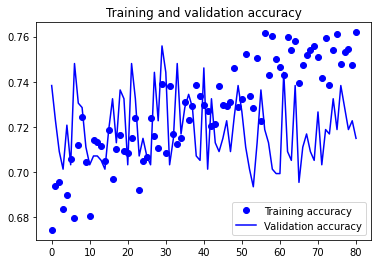

In [ ]:
plt_a = plot_acc(history_siamese)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

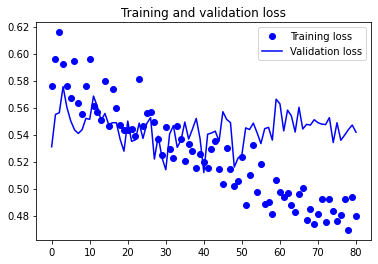

In [ ]:
plt_b = plot_loss(history_siamese)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
siamese = models.load_model('siamese_best.h5')
test_loss, test_accuracy = siamese.evaluate_generator(test_generator, steps=int(336/128))

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



---------------------------------
Accuracy: 66.41 %
---------------------------------



In [ ]:
pred = siamese.predict_generator(test_generator, steps=int(336/128))

pred_classes = np.rint(pred)
confusion_mtx = confusion_matrix(test_labels, pred_classes) 
plot_confusion_matrix(confusion_mtx, classes=range(2), normalize=False, title='Siamese CNN confusion matrix')

In [ ]:
plot_roc([pred], names=['Siamese CNN'])

In [ ]:
MODEL_PATH = os.path.join(base_path, "models/Baseline")
models.save_model(model, os.path.join(MODEL_PATH, 'Siamese_InceptionV3_ALLFT_DA_5x.h5'))